# Final LDA Model

In [39]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

from datetime import datetime

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
# import pyLDAvis.gensim  # Author: don't skip this
# pyLDAvis.gensim.prepare

# I think i need another one:
import pyLDAvis.gensim_models
import pyLDAvis.gensim_models as gensimvis

# Plots
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# TF.IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_distances

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('dutch')
stop_words.extend(['tenlastelegging\\n\\n\\naan', '\\n\\n\\n\\n\\n\\n', '\\n\\n\\n\\n\\n', '\\n\\n', 'een', 'naan', 'nde', 'nhij', '\\n'])

# Data Final

df = pd.read_csv('/Users/dj/Python - UvA/DSP/data/dataset_18_21.csv', index_col=6, parse_dates=['date']) 
df.head()


In [3]:
df = pd.read_csv('/Users/dj/Python - UvA/DSP/data/dataset_10012022_cleaned.csv', index_col=6, parse_dates=['date']) 
df.head()

df_be = df[df['bewijs'] != '[]'] #bewijs
df_te = df[df['tll'] != '[]'] #tenlastelegging

df['bete'] = df['bewijs'] + df['tll'] 
df = df[df['bete'] != '[][]']
df = df.drop(labels=['bewijs', 'tll'], axis=1)


# Data 2

In [4]:
df = pd.read_csv('/Users/dj/Python - UvA/DSP/data/dataset_18_21.csv', index_col=5, parse_dates=['date']) 
df = df.drop(labels=['ecli', 'case_nr', 'bewijs'], axis=1)
df = df.rename(columns={"tll": "bete"})
df.head()


,Unnamed: 0,subject,spatial,bete
date,,,,
2018-01-17,0,Strafrecht,Amsterdam,"[""['\\ntenlastelegging\\n\\n\\naan de verdacht..."
2018-01-17,1,Strafrecht,Amsterdam,"[""['\\ntenlastelegging\\n\\n\\naan de verdacht..."
2018-03-30,2,Strafrecht,Amsterdam,"[""['\\ntenlastelegging\\n\\n\\naan de verdacht..."
2018-03-30,3,Strafrecht,Amsterdam,"[""['\\ntenlastelegging\\n\\n\\naan de verdacht..."
2018-03-30,4,Strafrecht,Amsterdam,"[""['\\ntenlastelegging\\n\\n\\naan de verdacht..."


In [5]:
df18 = df.loc["2018-01-01 00:00:00":"2018-12-31 00:00:00"]
df19 = df.loc["2019-01-01 00:00:00":"2019-12-31 00:00:00"]
df20 = df.loc["2020-01-01 00:00:00":"2020-12-31 00:00:00"]
df21 = df.loc["2021-01-01 00:00:00":"2021-12-31 00:00:00"]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated 

In [6]:
print(df18.shape)
print(df19.shape)
print(df20.shape)
print(df21.shape)

(4222, 4)
(4266, 4)
(3922, 4)
(4036, 4)


# Build Giant Function

In [7]:

def get_lda_model(df):

    def sent_to_words(sentences):
        for sentence in sentences:
            yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

    data_words = list(sent_to_words(df['bete']))

        # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    nlp = spacy.load("nl_core_news_sm")

    def sent_to_words(sentences):
        for sentence in sentences:
            yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

    # Define functions for stopwords, bigrams, trigrams and lemmatization
    def remove_stopwords(texts):
        return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

    def make_bigrams(texts):
        return [bigram_mod[doc] for doc in texts]

    def make_trigrams(texts):
        return [trigram_mod[bigram_mod[doc]] for doc in texts]

    def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
        """https://spacy.io/api/annotation"""
        texts_out = []
        for sent in texts:
            doc = nlp(" ".join(sent)) 
            texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        return texts_out



    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)

    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)

    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
    # python3 -m spacy download en
    # nlp = spacy.load('nl', disable=['parser', 'ner'])

    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Create Dictionary
    id2word = corpora.Dictionary(data_lemmatized)

    # Create Corpus
    texts = data_lemmatized

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    # corpus1 = [str(item) for item in corpus]

    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=5, 
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)


    ######## TF.IDF ########

    dat_lem_untok = [" ".join(x) for x in data_lemmatized]
    tfidf_vectorizer = TfidfVectorizer(input=dat_lem_untok, stop_words=stop_words)
    tfidf_vector = tfidf_vectorizer.fit_transform(dat_lem_untok)
    tfidf_df = pd.DataFrame(tfidf_vector.toarray(), columns=tfidf_vectorizer.get_feature_names())
    tfidf_df = tfidf_df.stack().reset_index()
    tfidf_df = tfidf_df.rename(columns={0:'tfidf', 'level_0': 'document','level_1': 'term', 'level_2': 'term'})
    top_tfidf = tfidf_df.sort_values(by=['document','tfidf'], ascending=[True,False]).groupby(['document']).head(10)

     

    return(lda_model, data_lemmatized, corpus, id2word, top_tfidf)

In [8]:
d = [df18, df19, df20, df21]
q = 1
lda_models = []
dat_lems = []
corps = []
ids = []
top_idfs = []

for i in d:
    print(q)
    q += 1
    l, dl, c, i2words, t = get_lda_model(i)
    lda_models.append(l)
    dat_lems.append(dl)
    corps.append(c)
    ids.append(i2words)
    top_idfs.append(t)



1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['tenlastelegging'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


2
3
4


In [9]:
d[3]

,Unnamed: 0,subject,spatial,bete
date,,,,
2021-01-22,12410,Strafrecht,Amsterdam,"[""['\\ntenlastelegging\\n\\n\\ngelet op de in ..."
2021-01-22,12411,Strafrecht,Amsterdam,"[""['\\ntenlastelegging\\n\\n\\ngelet op de in ..."
2021-01-22,12412,Strafrecht,Amsterdam,"[""['\\ntenlastelegging\\n\\n\\naan de verdacht..."
2021-01-21,12413,Strafrecht,Amsterdam,"[""['\\ntenlastelegging\\n\\n\\naan de verdacht..."
2021-03-17,12414,Strafrecht,Amsterdam,"[""['\\ntenlastelegging\\n\\n\\naan de verdacht..."
...,...,...,...,...
2021-03-05,16441,Strafrecht,Middelburg,"[""[' tenlastelegging\\n\\nde tenlastelegging i..."
2021-03-05,16442,Strafrecht,Breda,"[""[' tenlastelegging\\n\\nde tenlastelegging i..."
2021-03-08,16443,Strafrecht,Breda,"[""[' tenlastelegging\\n\\nde tenlastelegging i..."


# Compute Model Perplexity and Coherence Score

In [10]:
# 18 = 0 / 19 = 1 / 20 = 2 / 21 = 3

a = 3

# Compute Perplexity
print('\nPerplexity: ', lda_models[a].log_perplexity(corps[a]))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_models[a], texts=dat_lems[a], dictionary=ids[a], coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.438915918427933

Coherence Score:  0.5460915434964918


# Visualize the topics-keywords

In [18]:
# 18 = 0 / 19 = 1 / 20 = 2 / 21 = 3

a = 0

# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_models[a], corps[a], ids[a], R = 10)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.339002  0.015016       1        1  33.499196
0     -0.120603  0.159486       2        1  18.194722
4     -0.153453 -0.154554       3        1  17.554984
2     -0.002678 -0.181491       4        1  16.007613
3     -0.062268  0.161542       5        1  14.743483, topic_info=            Term          Freq         Total Category  logprob  loglift
57   slachtoffer  47519.000000  47519.000000  Default  10.0000  10.0000
23          naam  44456.000000  44456.000000  Default   9.0000   9.0000
68       althans  25699.000000  25699.000000  Default   8.0000   8.0000
29         ander  20660.000000  20660.000000  Default   7.0000   7.0000
16       bedrijf   5893.000000   5893.000000  Default   6.0000   6.0000
..           ...           ...           ...      ...      ...      ...
68       althans   5730.215818  25699.668911   Topic5  -3.6595   0.4136
133      periode   3239.122295   8315.054668   Topic5  -4.2299   0.9716
13     verdenken   5303.321522  51525.773596   Topic5  -3.7369  -0.3594
29         ander   3439.108397  20660.696360   Topic5  -4.1700   0.1213
53         weten   2710.721381  10905.922517   Topic5  -4.4080   0.5223

[134 rows x 6 columns], token_table=      Topic      Freq                Term
term                                     
4434      4  0.998683         aangeefster
174       1  0.101635               adres
174       2  0.837204               adres
174       4  0.061084               adres
555       4  0.999338          afbeelding
...     ...       ...                 ...
981       1  0.949954                zien
981       4  0.046814                zien
981       5  0.003314                zien
345       3  0.998850   zwaar_lichamelijk
376       3  0.998477  zware_mishandeling

[232 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 5, 3, 4])

# TF.IDF 

In [12]:
test = top_idfs[0].sort_values(by=['tfidf'], ascending=[False]).head(20)

In [13]:
top_idfs[0].sort_values(by=['tfidf'], ascending=[False]).head(20)

,document,term,tfidf
41150994,1307,aangever,0.989249
41182479,1308,aangever,0.981069
102256145,3247,smokkelen,0.951879
9070238,288,bergen_nh,0.950756
64088720,2035,ninleiding,0.942529
99862311,3171,schag,0.934833
20015025,635,purmeren,0.927456
22116815,702,middenbeemster,0.926729
12198601,387,mb,0.898474
54802103,1740,ntoebehorenen,0.881753


In [14]:
top_idfs[3][top_idfs[3]['term'].str.contains('hof')]

,document,term,tfidf
629286,19,gerechtshof_toegelaten,0.180391
2196870,67,gerechtshof_toegelaten,0.175820
4680502,143,hof,0.261508
4809510,147,gerechtshof_toegelaten,0.494330
5658618,173,gerechtshof_toegelaten,0.212895
...,...,...,...
40212406,1231,hof,0.285734
40245064,1232,hof,0.245770
40277722,1233,hof,0.116328
49322363,1510,gerechtshof,0.331058


In [60]:
values = []
years = ('2018', '2019', '2020', '2021')
term = 'hof'

def avg_terms(data, term):
    avg = data[data['term'].str.contains(term)]['tfidf'].mean()
    return(avg)
    
for i in top_idfs:
    if term in list(i['term']):
        a  = avg_terms(i, term)
        values.append(a)
    else:
        values.append(0)

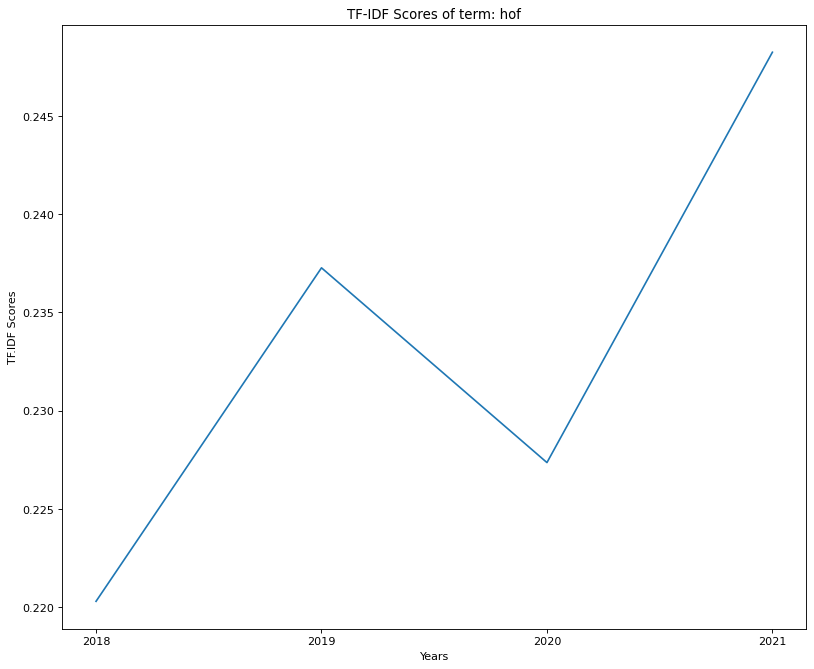

In [61]:
x_pos = [0,1,2,3]

figure(figsize=(12, 10), dpi=80)

plt.plot(values)


# Add title and axis names
plt.title('TF-IDF Scores of term: {}'.format(term))
plt.xlabel('Years')
plt.ylabel('TF.IDF Scores')
 
# Create names on the x axis
plt.xticks(x_pos, years)
 
# Show graph
plt.show()

In [17]:
values

[0.22029356934411393,
 0.23725846410656606,
 0.22735218050221442,
 0.24822594143610002]

In [66]:
'hof' in list(top_idfs[3]['term'])

True